https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html

# Ejemplo correlación lineal

CASO DE ESTUDIO

Vamos a realizar un estudio que pretenda analizar la existencia de una correlación entre altura-peso en las personas.

El set de datos contiene información recogida por Nancy Howell a finales de la década de 1960 sobre el pueblo !Kung San, que viven en el desierto de Kalahari entre Botsuana, Namibia y Angola.

# librerias

In [55]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sb

# Preprocesado y análisis
# ==============================================================================
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import pingouin as pg
from scipy import stats
from scipy.stats import pearsonr

# Configuración matplotlib
# ==============================================================================
plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#  datos

In [81]:
#leemos el DATAFRAME
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/Howell1.csv')
df = pd.read_csv(url)

In [60]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [8]:
df.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [82]:
# Se utilizan únicamente información de individuos mayores de 18 años.
df = df[df.age > 18]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  346 non-null    float64
 1   weight  346 non-null    float64
 2   age     346 non-null    float64
 3   male    346 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.5 KB


antes había 544 filas, ahora 346
los hombres son '1' en la columna 'male', y las mujeres son '0'

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
from sklearn.covariance import EllipticEnvelope

In [11]:
#descripción estadística de los datos numérico
df.describe() 

,height,weight,age,male
count,346.000000,346.000000,346.000000,346.000000
mean,154.644369,45.045543,41.539740,0.473988
std,7.773564,6.455220,15.809304,0.500046
min,136.525000,31.524644,19.000000,0.000000
25%,148.590000,40.334251,29.000000,0.000000
50%,154.305000,45.004831,40.000000,0.000000
75%,160.655000,49.377742,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [14]:
#nos creamos un nuevo df solo con los valores numéricos
#eliminar las columnas constantes, variables "dummy", variables como "meses" (que a pesar de ser numéricas, no tiene lógica hayar su correlación)

#eliminamos los datos faltantes de df2
df.dropna(inplace = True)

#mostramos la matriz de correlaciones
#np.corrcoef(df2["area"],df2["geoname_id"],df2["numeric"],df2["population"])
df.corr()
corr = round(df.corr(),3)
corr.style.background_gradient()


,height,weight,age,male
height,1.000000,0.753000,-0.113000,0.701000
weight,0.753000,1.000000,-0.190000,0.526000
age,-0.113000,-0.190000,1.000000,0.014000
male,0.701000,0.526000,0.014000,1.000000


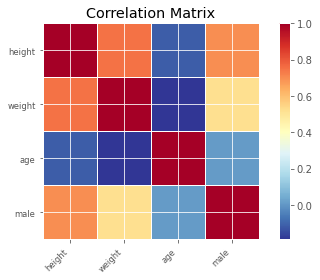

In [17]:
#correlación entre datos
corr = df.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

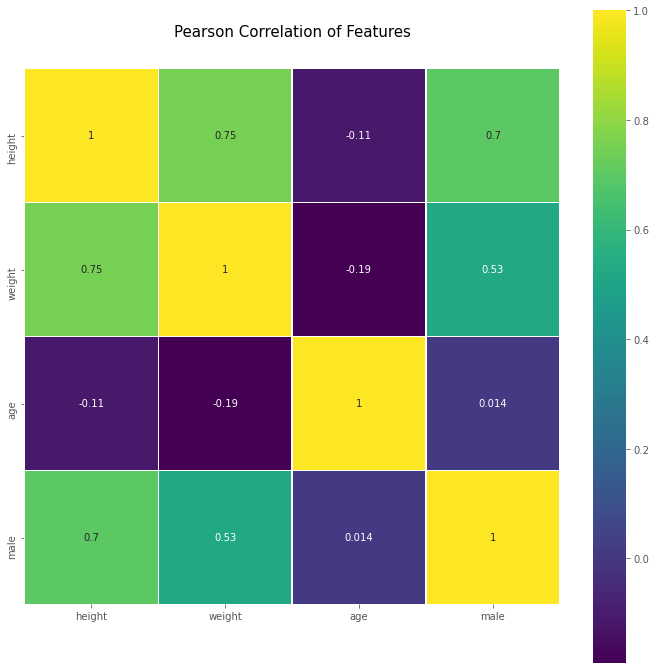

In [19]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Análisis gráfico

En primer lugar, representaremos las dos variables 

ALTURA VS PESO

mediante un diagrama de dispersión (scatterplot) para intuir si existe relación lineal o monotónica. 

Si no la hay, no tiene sentido calcular este tipo de correlaciones

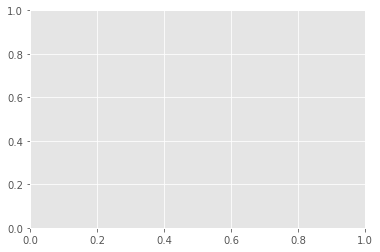

In [20]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(6,4))

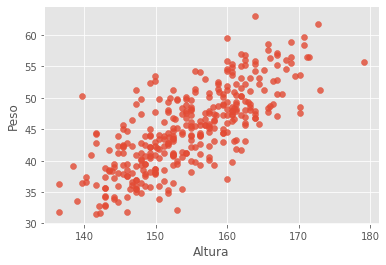

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
#ALTURA VS PESO
ax.scatter(x=df.height, y=df.weight, alpha= 0.8)
ax.set_xlabel('Altura')
ax.set_ylabel('Peso');

El diagrama de dispersión parece indicar una relación lineal positiva entre ambas variables.

Para poder elegir el coeficiente de correlación adecuado, se tiene que analizar el tipo de variables y la distribución que presentan. En este caso, ambas variables son cuantitativas continuas y pueden ordenarse para convertirlas en un ranking, por lo que, a priori, los tres coeficientes podrían aplicarse. 

La elección se hará en función de la distribución que presenten las observaciones: 
- normalidad, 
- homocedasticidad y 
- presencia de outliers.

### NORMALIDAD

A continuación, vamos a estudiar la normalidad para la columna de 'altura' y 'peso', con el objetivo de clarificar si dichos datos, siguen una distribución próxima a la normal.

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

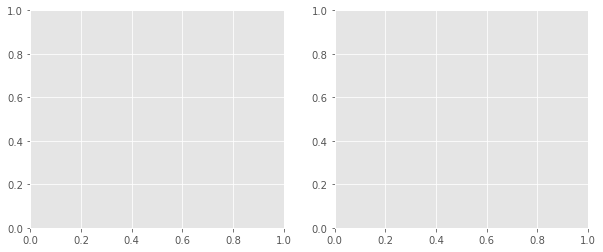

In [36]:
# Gráfico distribución variables
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs #array con dos subplots, axs[0] y axs[1]

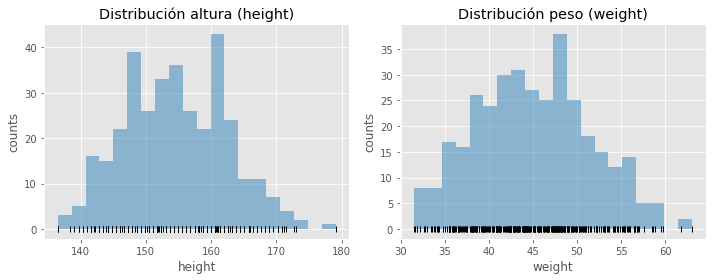

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#HISTOGRAMAS para ver la normalidad a ojo
#altura
axs[0].hist(x=df.height, bins=20, color="#3182bd", alpha=0.5)
axs[0].plot(df.height, np.full_like(df.height, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución altura (height)')
axs[0].set_xlabel('height')
axs[0].set_ylabel('counts')
#peso
axs[1].hist(x=df.weight, bins=20, color="#3182bd", alpha=0.5)
axs[1].plot(df.weight, np.full_like(df.weight, -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Distribución peso (weight)')
axs[1].set_xlabel('weight')
axs[1].set_ylabel('counts')


plt.tight_layout();

In [28]:
np.full_like(df.height, -0.01) #Return a full array with the same shape and type as a given array

array([-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01,

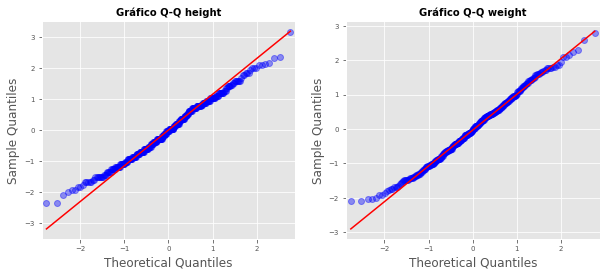

In [42]:
# Gráfico Q-Q (quantile-quantile)
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs #array con dos subplots, axs[0] y axs[1]

#import statsmodels.api as sm
#altura
sm.qqplot(
    df.height,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = axs[0]
)
axs[0].set_title('Gráfico Q-Q height', fontsize = 10, fontweight = "bold")
axs[0].tick_params(labelsize = 7)
#peso
sm.qqplot(
    df.weight,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = axs[1]
)
axs[1].set_title('Gráfico Q-Q weight', fontsize = 10, fontweight = "bold")
axs[1].tick_params(labelsize = 7)

lo ideal sería que los pts se acerquen a una recta diagonal (es el caso?)

Además del estudio gráfico, se recurre a dos test estadísticos que contrasten la normalidad de los datos:

- Shapiro-Wilk test
- D'Agostino's K-squared test

Este último es el que incluye el summary de statsmodels bajo el nombre de Omnibus

En ambos test, la hipótesis nula considera que los datos siguen una distribución normal, por lo tanto, si el p-value no es inferior al nivel de referencia alpha seleccionado, no hay evidencias para descartar que los datos se distribuyen de forma normal.

In [44]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(df.height)
print(f"Variable height: {shapiro_test}")
shapiro_test = stats.shapiro(df.weight)
print(f"Variable weight: {shapiro_test}")

Variable height: ShapiroResult(statistic=0.9910696148872375, pvalue=0.03439393267035484)
Variable weight: ShapiroResult(statistic=0.9911819696426392, pvalue=0.03673496097326279)


In [46]:
# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(df.height)
print(f"Variable height: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(df.weight)
print(f"Variable weight: Estadítico = {k2}, p-value = {p_value}")

Variable height: Estadítico = 7.210790495766356, p-value = 0.02717670115638557
Variable weight: Estadítico = 8.402628478646022, p-value = 0.014975881988445145


El análisis gráfico y los test estadísticos muestran evidencias de que no se puede asumir normalidad en ninguna de las dos variables. 

Siendo estrictos, este hecho excluye la posibilidad de utilizar el coeficiente de Pearson, dejando como alternativas el de Spearman o Kendall. 

Sin embargo, dado que la distribución no se aleja mucho de la normalidad y de que el coeficiente de Pearson tiene cierta robustez, a fines prácticos sí que se podría utilizar siempre y cuando se tenga en cuenta este hecho y se comunique en los resultados. 

Otra posibilidad es tratar de transformar las variables para mejorar su distribución, por ejemplo, aplicando el logaritmo:

Variable height: ShapiroResult(statistic=0.9922674894332886, pvalue=0.06951289623975754)


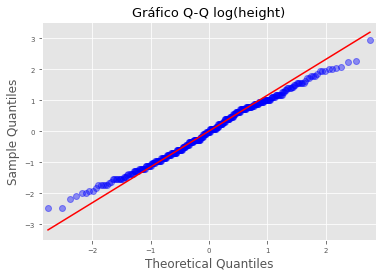

In [50]:
# Transformación logarítmica de los datos
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

sm.qqplot(
    np.log(df.height), #AQUI
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q log(height)', fontsize = 13)
ax.tick_params(labelsize = 7)


shapiro_test = stats.shapiro(np.log(df.height))
print(f"Variable height: {shapiro_test}")

Si comparamos esta gráfica (aplicada la transformación logarítmica), con la gráfica sin aplicar la transformación logarítmica:

Variable height: ShapiroResult(statistic=0.9910696148872375, pvalue=0.03439393267035484)


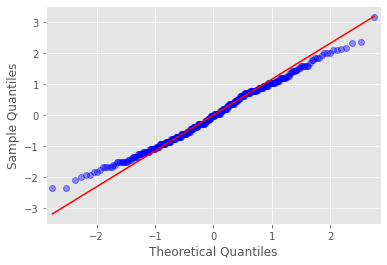

In [51]:
# Gráfico Q-Q (quantile-quantile)
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

#import statsmodels.api as sm
#altura
sm.qqplot(
    df.height,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
axs[0].set_title('Gráfico Q-Q height', fontsize = 10, fontweight = "bold")
axs[0].tick_params(labelsize = 7)

shapiro_test = stats.shapiro(df.height)
print(f"Variable height: {shapiro_test}")

La trasformación logarítmica de la variable altura (height) consigue una distribución más próxima a la normal
- pvalue_log=0.06951289623975754
- pvalue=0.03439393267035484

# Homocedasticidad

La homocedasticidad implica que la varianza se mantiene constante. 

(la varianza de Y debe ser constante a lo largo de la variable X)

Puede analizarse de forma gráfica representando las observaciones en un diagrama de dispersión (scatter) y viendo si mantiene una homogeneidad en su dispersión a lo largo del eje X. 
(en un scatterplot los valores de Y mantienen la misma dispersión en las distintas zonas de la variable X)

Una forma cónica es un claro indicativo de falta de homocedasticidad. Dos test estadísticos utilizados para contrastar la homocedasticidad son: 
- test de Goldfeld-Quandt 
- el de Breusch-Pagan.

Tal como muestra el diagrama de dispersión generado al inicio del ejercicio, no se aprecia ningún patrón cónico y la dispersión es constante.

https://www.geeksforgeeks.org/goldfeld-quandt-test/

https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html

In [56]:
sm_stats.diagnostic.het_goldfeldquandt(y=df.weight,x=df.height)


ValueError: not enough values to unpack (expected 2, got 1)

# presencia de OUTLIERS

In [121]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/Howell1.csv')
df = pd.read_csv(url)
df = df[df.age > 18]

In [122]:
from sklearn.covariance import EllipticEnvelope
#definimos los outliers
outliers = EllipticEnvelope(contamination = 0.01) 
outliers
#definimos nuestro DataFrame con 'height' y 'weight'
df.drop(['age','male'],axis = 1, inplace = True)
var_list = ['height','weight'] #lista de variables de la base de datos
#defino una variable 'x' que son los valores que nos interesan de nuestra base de datos
x = np.array(df.loc[:,var_list].dropna())
x
#entrenamos nuestro modelo
outliers.fit(x)
#pedir que nos prediga con este modelo, los valores que forman parte de ese 1% que queremos detectar
pred = outliers.predict(x)
pred #array de '1' y '-1' --> quiero detectar los '-1'
elips_outliers = np.where(pred == -1)[0]
elips_outliers #lista con los index de aquellos casos que son outliers --> LAS POSICIONES NO LOS INDICES

#MUCHISIMO CUIDADO, HE PODIDO CAMBIAR MI DATAFRAME APLICANDO FILTROS AL ORIGINAL, Y HABER ELIMINADO INDEX. 
#POR LO QUE LO QUE ME DA 'elips_outliers', NO SON LOS ÍNDICES, SINO LAS POSICIONES (EMPEZANDO DESDE EL 0)

array([  5,  70, 114, 310], dtype=int64)

In [129]:
len(df.iloc[elips_outliers,:])
df.iloc[elips_outliers,:]

,height,weight
5,163.83,62.992589
93,179.07,55.706768
159,149.86,53.438807
478,139.70,50.348712


In [130]:
#podría intentar sacar los índices en un array [5,93,159,478]
#np.where(df.iloc[elips_outliers,:])

(array([0, 0, 1, 1, 2, 2, 3, 3], dtype=int64),
 array([0, 1, 0, 1, 0, 1, 0, 1], dtype=int64))

In [124]:
df.drop([5,70,114,310],axis=0,inplace=True) #va a dar ERROR

KeyError: '[ 70 114] not found in axis'

In [126]:
#df.loc[[5,  70, 114, 310],:]
#df.loc[70]
df.head(60) #vemos que no hay indice 70, porque sería un menor de 18 que ha quedado fuera del primer filtro al df

,height,weight
0,151.7650,47.825606
1,139.7000,36.485807
2,136.5250,31.864838
3,156.8450,53.041915
4,145.4150,41.276872
5,163.8300,62.992589
6,149.2250,38.243476
7,168.9100,55.479971
8,147.9550,34.869885
9,165.1000,54.487739


In [128]:
#tengo que volver a igualar los índices, a las posiciones
df_index = df.set_index(np.arange(346))
df_index.head(75)
#ahora sí que se corresponden las posiciones con los indices
df_index.drop([5,70,114,310],axis=0,inplace=True)
#df_index.drop(elips_outliers,axis=0,inplace=True)

,height,weight
0,151.765,47.825606
1,139.700,36.485807
2,136.525,31.864838
3,156.845,53.041915
4,145.415,41.276872
...,...,...
70,179.070,55.706768
71,170.180,48.562694
72,146.050,42.807745
73,147.320,35.068331


In [131]:
#apartir de aqui ya no tenemos outliers
#volvemos a realizar los tests de antes

#CON OUTLIERS
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(df.height)
print(f"Variable height: {shapiro_test}")
shapiro_test = stats.shapiro(df.weight)
print(f"Variable weight: {shapiro_test}")

# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(df.height)
print(f"Variable height: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(df.weight)
print(f"Variable weight: Estadítico = {k2}, p-value = {p_value}")

#SIN OUTLIERS
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(df_index.height)
print(f"Variable height: {shapiro_test}")
shapiro_test = stats.shapiro(df_index.weight)
print(f"Variable weight: {shapiro_test}")

# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(df_index.height)
print(f"Variable height: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(df_index.weight)
print(f"Variable weight: Estadítico = {k2}, p-value = {p_value}")

Variable height: ShapiroResult(statistic=0.9910696148872375, pvalue=0.03439393267035484)
Variable weight: ShapiroResult(statistic=0.9911819696426392, pvalue=0.03673496097326279)
Variable height: Estadítico = 7.210790495766356, p-value = 0.02717670115638557
Variable weight: Estadítico = 8.402628478646022, p-value = 0.014975881988445145
Variable height: ShapiroResult(statistic=0.9910696148872375, pvalue=0.03439393267035484)
Variable weight: ShapiroResult(statistic=0.9911819696426392, pvalue=0.03673496097326279)
Variable height: Estadítico = 7.210790495766356, p-value = 0.02717670115638557
Variable weight: Estadítico = 8.402628478646022, p-value = 0.014975881988445145


#### OTRA FORMA

In [132]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/Howell1.csv')
df = pd.read_csv(url)
df = df[df.age > 18]

df.height #X
df.weight #Y

media_x = df.weight.mean()
std_x = df.weight.std()*2
media_y = df.height.mean()
std_y = df.height.std()*2

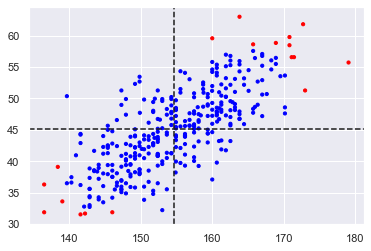

In [133]:
#formamos una matriz de colores
colors = ['blue']*len(df.weight)
enumerate(df.weight)
#si Valor-media > std --> outlier
for index, x in enumerate(df.weight):
    if abs(x-media_x) > std_x:
        colors[index] = 'red'
        
for index, x in enumerate(df.height):
    if abs(x-media_y) > std_y:
        colors[index] = 'red'
#VISUALIZAMOS
plt.scatter(df.height, df.weight, s=10, color=colors) #X,Y
plt.axhline(media_x, color='k', linestyle='--') #eje horizontal centrado en la media_x
plt.axvline(media_y, color='k', linestyle='--') #eje vertical centrado en la media_y

### cómo afectan los outliers

<AxesSubplot:xlabel='height', ylabel='weight'>

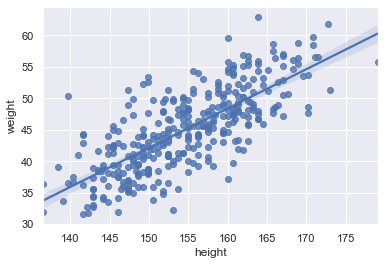

In [134]:
import seaborn as sns
#CON OUTLIERS
sns.set(color_codes=True)
sns.regplot(x=df.height, y=df.weight) #Plot data and a linear regression model fit.

In [135]:
# SIN OUTLIERS

#1º quito los Outliers de mis datos
height_fix=[] #lista vacia en la que ir guardando los valores sin outliers
weight_fix=[] #lista vacia en la que ir guardando los valores sin outliers

for index, x in enumerate(df.weight):
    y= df.height[index]
    if abs(x-media_x) > std_x or abs(y-media_y) > std_y: #si en la iteración, el caso es un outlier
        pass
    else:
        height_fix.append(y) #voy guardando los casos que no son outliers
        weight_fix.append(x) #voy guardando los casos que no son outliers

#Plot data and a linear regression model fit.
sns.set(color_codes=True)
sns.regplot(x=np.array(height_fix), y=np.array(weight_fix)) #Plot data and a linear regression model fit.

KeyError: 18

# Coeficientes correlación

Debido a la falta de normalidad, los resultados generados por Pearson no son del todo precisos. 

Sin embargo, dado que la desviación de la normalidad es leve y no se aprecian outliers, con fines ilustrativos, se procede a calcular los tres tipos de coeficientes.

De nuevo recordar que, *cuando alguna de las condiciones asumidas por un modelo o test estadístico no se cumplen, no significa que obligatoriamente se tenga que descartar, pero hay que ser consciente de las implicaciones que tiene y reportarlo siempre en los resultados.*

#### utilizando Pandas
Pandas permite calcular la correlación de dos Series (columnas de un DataFrame). 
- El cálculo se hace por pares, eliminando automáticamente aquellos con valores NA/null. 
- Una limitación de Pandas es que no calcula la significancia estadística.

In [136]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/Howell1.csv')
df = pd.read_csv(url)
df = df[df.age > 18]

In [137]:
# Cálculo de correlación con Pandas
# ==============================================================================
print('Correlación Pearson: ', df['weight'].corr(df['height'], method='pearson'))
print('Correlación spearman: ', df['weight'].corr(df['height'], method='spearman'))
print('Correlación kendall: ', df['weight'].corr(df['height'], method='kendall'))

Correlación Pearson:  0.7528177220327672
Correlación spearman:  0.7510966609219974
Correlación kendall:  0.5639709660523899


#### utilizando Scypy.stats
La implementación de Scypy.stats sí permite calcular la significancia estadística además del coeficiente de correlación. 

La función *stats.pearsonr()*, devuelve un error si alguna de las observaciones contienen valores NA/null. 

Las funciones *stats.spearmanr() y stats.kendalltau()* sí permiten excluirlos de forma automática si se indica *nan_policy='omit'*.

In [138]:
# Cálculo de correlación y significancia con Scipy
# ==============================================================================
r, p = stats.pearsonr(df['weight'], df['height'])
print(f"Correlación Pearson: r={r}, p-value={p}")

r, p = stats.spearmanr(df['weight'], df['height'])
print(f"Correlación Spearman: r={r}, p-value={p}")

r, p = stats.kendalltau(df['weight'], df['height'])
print(f"Correlación Pearson: r={r}, p-value={p}")

Correlación Pearson: r=0.7528177220327668, p-value=1.8941037794177617e-64
Correlación Spearman: r=0.7510966609219974, p-value=5.2882247217804375e-64
Correlación Pearson: r=0.5639709660523899, p-value=3.162649137764771e-54


#### utilizando Pingouin
La librería Pingouin tiene una de las implementaciones más completas. 

Con la función *corr()* se obtiene, además del coeficiente de correlación, su significancia, intervalo de confianza y poder estadístico entre otros.

In [139]:
# Cálculo de correlación, significancia e intervalos con pingouin
# ==============================================================================
display(pg.corr(df['weight'], df['height'], method='pearson'))
display(pg.corr(df['weight'], df['height'], method='spearman'))
display(pg.corr(df['weight'], df['height'], method='kendall'))

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,346,0.752818,"[0.7, 0.8]",0.566735,0.564208,1.894104e-64,8.84e+60,1.0


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,346,0.751097,"[0.7, 0.79]",0.564146,0.561605,5.288225e-64,1.0


,n,r,CI95%,r2,adj_r2,p-val,power
kendall,346,0.563971,"[0.49, 0.63]",0.318063,0.314087,3.162649e-54,1.0


# conclusión
Los test estadísticos muestran una correlación lineal entre moderada y alta, con claras evidencias estadísticas de que la relación observada no se debe al azar ( pvalue≈0 )

# Ejemplo Jackknife correlation

CASO DE ESTUDIO:

Un equipo de investigadores quiere estudiar si existe correlación en la presencia de dos sustancias (A y B) en el agua de los ríos. 

Para ello han realizado una serie de mediciones en las que se cuantifica la concentración de las dos sustancias en 10 muestras independientes de agua. Se sospecha que el instrumento de lectura sufre alguna avería que provoca que algunas lecturas se disparen, por esta razón se quiere emplear un método de correlación robusto. El objetivo de este ejemplo es ilustrar el método de Jackknife, por lo que se asume que se cumplen las condiciones para la correlación de Pearson.

In [140]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y análisis
# ==============================================================================
import statsmodels.api as sm
import pingouin as pg
from scipy import stats
from scipy.stats import pearsonr

# Configuración matplotlib
# ==============================================================================
plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

###### Datos

In [142]:
# Datos simulados de dos variables A y B
a = np.array([12,9,6,7,2,5,4,0,1,8]) #ID muestra
b = np.array([3,5,1,9,5,3,7,2,10,5]) #Concentración

# Se introduce un outlier
a[5] = 20
b[5] = 16

###### Visualizacion

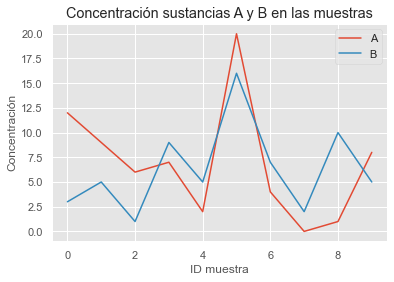

In [143]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(a, label='A')
ax.plot(b, label='B')
ax.set_xlabel('ID muestra')
ax.set_ylabel('Concentración')
ax.set_title('Concentración sustancias A y B en las muestras')
ax.legend();

###### Correlación de Pearson
Se procede a calcular la correlación de Pearson con y sin el outlier.

In [144]:
#from scipy import stats
#from scipy.stats import pearsonr

# Correlación con outlier
r, p = stats.pearsonr(a, b)
print(f"Correlación Pearson con outlier: r={r}, p-value={p}")

# Correlación sin outlier
r, p = stats.pearsonr(np.delete(a, 5), np.delete(b, 5))
print(f"Correlación Pearson sin outlier: r={r}, p-value={p}")

Correlación Pearson con outlier: r=0.5173731151689152, p-value=0.12563522982639527
Correlación Pearson sin outlier: r=-0.18420184544326057, p-value=0.6351961086690547


Se confirma que, La observación número 5, tiene una gran influencia en el resultado de la correlación, siendo de 0.52 si está presente y de -0.18 si se excluye

###### Jackknife Pearson correlation

In [145]:
# Función Jackknife correlation
# ==============================================================================

def correlacion_jackknife(x, y):
    '''
    Esta función aplica el método de Jackknife para el cálculo del coeficiente
    de correlación de Pearson.
    
    
    Parameters
    ----------
    x : 1D np.ndarray, pd.Series 
        Variable X.
        
    y : 1D np.ndarray, pd.Series
        Variable y.     

    Returns 
    -------
    correlaciones: 1D np.ndarray
        Valor de correlación para cada iteración de Jackknife
    '''
    
    n = len(x)
    valores_jackknife = np.full(shape=n, fill_value=np.nan, dtype=float)
    
    for i in range(n):
        # Loop para excluir cada observación y calcular la correlación
        r = stats.pearsonr(np.delete(x, i), np.delete(y, i))[0]
        valores_jackknife[i] = r

    promedio_jackknife = np.nanmean(valores_jackknife)
    standar_error = np.sqrt(((n - 1) / n) * \
                    np.nansum((valores_jackknife - promedio_jackknife) ** 2))
    bias = (n - 1) * (promedio_jackknife - stats.pearsonr(x, y)[0])
    
    resultados = {
        'valores_jackknife' : valores_jackknife,
        'promedio'          : promedio_jackknife,
        'se'                : standar_error,
        'bias'              : bias
    }
    
    return resultados

In [146]:
correlacion = correlacion_jackknife(x=a, y=b)
print(f"Correlación jackknife: {correlacion['promedio']}")
print(f"Error estándar: {correlacion['se']}")
print(f"Error bias: {correlacion['bias']}")
print(f"Valores_jackknife: {correlacion['valores_jackknife']}")

Correlación jackknife: 0.4781856690553491
Error estándar: 0.6915097651492329
Error bias: -0.35268701502209454
Valores_jackknife: [ 0.64719522  0.53705998  0.54597653  0.52827609  0.51215595 -0.18420185
  0.53554935  0.44125573  0.69065085  0.52793883]


Para identificar si existe algún valor muy influyente, se puede graficar el cambio que produce en el coeficiente de regresión la exclusión de cada observación.

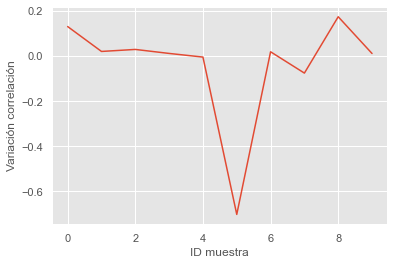

In [147]:
variacion_corr = correlacion['valores_jackknife'] - stats.pearsonr(a, b)[0]
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(variacion_corr)
ax.set_xlabel('ID muestra')
ax.set_ylabel('Variación correlación');

El método Jackknife correlation solo ha sido capaz de amortiguar una pequeña parte de la influencia del outlier, sin embargo, sí ha permitido identificar qué observación está afectando en mayor medida.

# Ejemplo matriz de correlaciones
Cuando se dispone de múltiples variables numéricas, por ejemplo en problemas de modelado estadístico y machine learning, es conveniente estudiar el grado de correlación entre las variables disponibles.

Una forma de hacerlo es mediante matrices de correlación, en las que se muestra el coeficiente de correlación para cada par de variables

In [156]:
# Datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/SaratogaHouses.csv')
datos = pd.read_csv(url, sep=",")

# Se renombran las columnas para que sean más descriptivas
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]
       
# Nos quedamos solo con los valores de las Variables numéricas
datos = datos.select_dtypes(include=['float64', 'int64'])

In [157]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   precio             1728 non-null   int64  
 1   metros_totales     1728 non-null   float64
 2   antiguedad         1728 non-null   int64  
 3   precio_terreno     1728 non-null   int64  
 4   metros_habitables  1728 non-null   int64  
 5   universitarios     1728 non-null   int64  
 6   dormitorios        1728 non-null   int64  
 7   chimenea           1728 non-null   int64  
 8   banyos             1728 non-null   float64
 9   habitaciones       1728 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 135.1 KB


In [158]:
# Matriz de correlación
# ==============================================================================
corr_matrix = datos.corr(method='pearson')
corr_matrix

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones
precio,1.000000,0.158333,-0.188793,0.581266,0.712390,0.200119,0.400349,0.376786,0.597250,0.531170
metros_totales,0.158333,1.000000,-0.016352,0.059222,0.163450,-0.033148,0.113982,0.085226,0.084823,0.137604
antiguedad,-0.188793,-0.016352,1.000000,-0.021818,-0.174242,-0.037785,0.027125,-0.172022,-0.361897,-0.082264
precio_terreno,0.581266,0.059222,-0.021818,1.000000,0.423441,0.228427,0.202449,0.211727,0.297498,0.298865
metros_habitables,0.712390,0.163450,-0.174242,0.423441,1.000000,0.209981,0.656196,0.473788,0.718564,0.733666
universitarios,0.200119,-0.033148,-0.037785,0.228427,0.209981,1.000000,0.162919,0.246626,0.179541,0.157068
dormitorios,0.400349,0.113982,0.027125,0.202449,0.656196,0.162919,1.000000,0.284475,0.458033,0.671863
chimenea,0.376786,0.085226,-0.172022,0.211727,0.473788,0.246626,0.284475,1.000000,0.436234,0.319894
banyos,0.597250,0.084823,-0.361897,0.297498,0.718564,0.179541,0.458033,0.436234,1.000000,0.517585
habitaciones,0.531170,0.137604,-0.082264,0.298865,0.733666,0.157068,0.671863,0.319894,0.517585,1.000000


Las matrices de correlación tienen el inconveniente de tener un tamaño notable cuando se dispone de muchas variables. 

Para facilitar la identificación de pares de variables con correlaciones altas, es conveniente convertirlas en formato de tabla larga (tidy).

In [160]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

tidy_corr_matrix(corr_matrix)

,variable_1,variable_2,r,abs_r
94,habitaciones,metros_habitables,0.733666,0.733666
49,metros_habitables,habitaciones,0.733666,0.733666
84,banyos,metros_habitables,0.718564,0.718564
48,metros_habitables,banyos,0.718564,0.718564
4,precio,metros_habitables,0.712390,0.712390
...,...,...,...,...
26,antiguedad,dormitorios,0.027125,0.027125
23,antiguedad,precio_terreno,-0.021818,0.021818
32,precio_terreno,antiguedad,-0.021818,0.021818
21,antiguedad,metros_totales,-0.016352,0.016352


Realizamos un mapa de calor para ver mejor las correlaciones

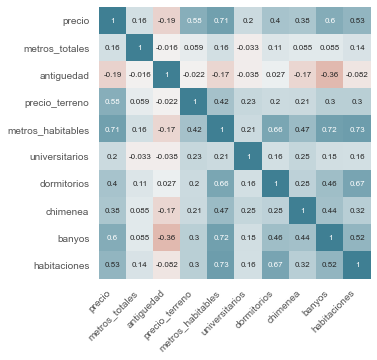

In [161]:
#import seaborn as sns

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

# Ejemplo correlación parcial
CASO DE ESTUDIO:

Se quiere estudiar la relación entre las variables precio y peso de los automóviles. Se sospecha que esta relación podría estar influenciada por la variable potencia del motor, ya que a mayor peso del vehículo se requiere mayor potencia y, a su vez, motores más potentes son más caros.

##### DATOS
Para este ejemplo se utiliza el set de datos Cars93 disponible en el paquete de R MASS

In [162]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/Cars93.csv')
datos = pd.read_csv(url)
datos['log_Price'] = np.log(datos.Price)

In [164]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Manufacturer        93 non-null     object 
 1   Model               93 non-null     object 
 2   Type                93 non-null     object 
 3   Min.Price           93 non-null     float64
 4   Price               93 non-null     float64
 5   Max.Price           93 non-null     float64
 6   MPG.city            93 non-null     int64  
 7   MPG.highway         93 non-null     int64  
 8   AirBags             93 non-null     object 
 9   DriveTrain          93 non-null     object 
 10  Cylinders           93 non-null     object 
 11  EngineSize          93 non-null     float64
 12  Horsepower          93 non-null     int64  
 13  RPM                 93 non-null     int64  
 14  Rev.per.mile        93 non-null     int64  
 15  Man.trans.avail     93 non-null     object 
 16  Fuel.tank.

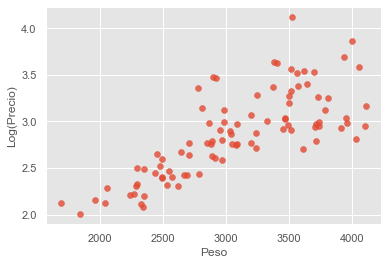

In [163]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=datos.Weight, y=datos.log_Price, alpha= 0.8)
ax.set_xlabel('Peso')
ax.set_ylabel('Log(Precio)');

El gráfico muestra una clara relación lineal entre el peso de un coche y el logaritmo de su precio.

#### correlación

In [165]:
# Cálculo de correlación lineal
# ==============================================================================
pg.corr(x=datos['Weight'], y=datos['log_Price'], method='pearson')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,93,0.763544,"[0.66, 0.84]",0.582999,0.573733,5.640674e-19,1.069e+16,1.0


In [166]:
# Cálculo de correlación lineal parcial
# ==============================================================================
pg.partial_corr(data=datos, x='Weight', y='log_Price', covar='Horsepower', method='pearson')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,93,0.404741,"[0.22, 0.56]",0.163816,0.145234,0.000057,374.629,0.983505


CONCLUSIÓN:

La correlación entre el peso y el logaritmo del precio es alta (r=0.764) y significativa ( pvalue≈0 ). Sin embargo, cuando se estudia su relación bloqueando la variable potencia de motor, a pesar de que la relación sigue siendo significativa, pasa a ser baja (r=0.4047).

Se puede afirmar que, la relación lineal existente entre el peso y el logaritmo del precio, está influenciada por el efecto de la variable potencia de motor.